In [2]:
from cri.transforms import euler2quat, quat2euler, transform, inv_transform, euler2mat, mat2euler
from cri.controller import Mg400Controller as Controller
from cri.robot import SyncRobot
from robopush.utils import Namespace, transform_euler, inv_transform_euler
from robopush.tracker import ArUcoTracker, display_fn, NoMarkersDetected, MultipleMarkersDetected
from robopush.detector import ArUcoDetector
from robopush.camera import RSCamera, ColorFrameError, DepthFrameError, DistanceError
import time
import matplotlib.pyplot as plt
import torch
from ipdb import set_trace
import numpy as np
import cv2
import os
import sys
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


In [3]:
# color_size = (1920, 1080)
depth_size = (848, 480)
# RS_RESOLUTION = (640, 480)
RS_RESOLUTION = (1920, 1080)
def make_realsense():
    return RSCamera(color_size=RS_RESOLUTION, color_fps=30, depth_size=depth_size, depth_fps=30)

rs_camera = make_realsense()
rs_detector = ArUcoDetector(rs_camera, marker_length=32.0, dict_id=cv2.aruco.DICT_7X7_50)
# set_trace()
rs_tracker = ArUcoTracker(rs_detector, track_attempts=30, num_marker_expected=1, display_fn=None)

try:
    rs_tracker.track()
except (ColorFrameError, DepthFrameError, DistanceError, \
        NoMarkersDetected, MultipleMarkersDetected) as e:
        print(e)
        sys.exit('Issue with Realsense Tracking.')
print(rs_tracker.detector.centroids)
print(rs_detector.centroids)
print(rs_tracker.detector.centroid_positions)
print(mat2euler(rs_tracker.pose))


[[[1111.25  368.75]]]
[[[1111.25  368.75]]]
[[ 59.27789307 -77.04187775 546.        ]]
[ 6.64602784e+01 -8.61204045e+01  6.10519520e+02  1.47083061e+02
 -2.40009277e-01  9.19683643e+01]


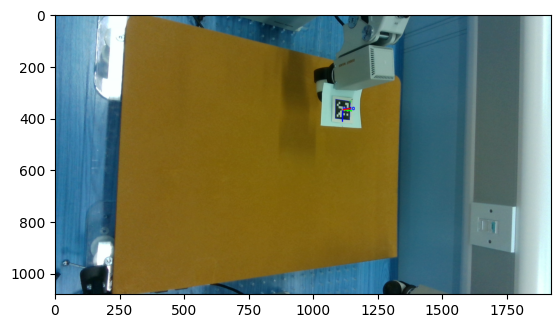

rs_tracker.detector.centroids: [[[1111.25  368.75]]]
rs_tracker.detector.centroid_positions [[ 59.27789307 -77.04187775 546.        ]]


AssertionError: Invalid 4x4 homogeneous matrix pose

In [4]:


 # Display ArUco marker
marker_image = rs_detector.draw_markers(rs_camera.color_image)
# cv2.imwrite(str(m.image_dir/("image_" + str(n_detected) + ".jpg")), marker_image)
# cv2.imshow("Detected marker", marker_image)
# cv2.waitKey(1)
plt.imshow(marker_image)
plt.show()
print("rs_tracker.detector.centroids:",rs_tracker.detector.centroids)
# print('rs_detector.centroids:',rs_detector.centroids)
print('rs_tracker.detector.centroid_positions',rs_tracker.detector.centroid_positions)
for pose in rs_tracker.pose:
    print("pose:",mat2euler(pose))

In [8]:
m = Namespace()

# Data dirs
m.calib_dir = r'C:\Users\Lenovo\dev\cri\tactile_gym_sim2real_dev\tactile_gym_sim2real\online_experiments\bi_push_env\realsense_params\dynamics\calib\MG400_calibration_latest'
# m.calib_dir = m.root_dir/("calib_" + time.strftime('%m%d%H%M'))
m.image_dir = os.path.join(m.calib_dir, "images")
os.makedirs(m.image_dir, exist_ok=True)

base_frame = (0, 0, 0, 0, 0, 0)
# work_frame = (0, 0, 0, 0, 0, 0)  # base frame: x->front, y->left, z->up, rz->anticlockwise
# work_frame = (350.0, 0, -25, 0, 0, 0)  # base frame: x->front, y->left, z->up, rz->anticlockwise, for rotate, gather
work_frame = (380.0, 0, -25, 0, 0, 0)  # base frame: x->front, y->left, z->up, rz->anticlockwise, for push

# base_start_pose_in_wf = np.array([250, 0, 0, 0, 0, 0])
base_start_pose_in_wf = np.array([0.0, 0, 0, 0, 0, 0])
# base_home_pose_in_wf = (250, 0, 0, 0, 0, 0)
base_home_pose_in_wf = (0.0, 0, 0, 0, 0, 0)

# x_rng = [0, 220]
x_rng = [-100, 70]
y_rng = [-180, 180]
# z_rng = [-50, -10]
z_rng = [-5, 50]
alpha_rng = [0, 0]
beta_rng = [0, 0]
gamma_rng = [0, 0]

n_samples = 20

sensor_offset = 0

m.base_poses, m.centroids, m.centroid_positions, m.rvecs, m.tvecs, m.cam_poses = [], [], [], [], [], []

# cali_points = np.array([
#     [20, -150, -20, 0, 0, 0],
#     [20, -150, 50, 0, 0, 0],
#     [140, -150, 50, 0, 0, 0],
#     [140, -150, 20, 0, 0, 0],
#     [20, 150, -20, 0, 0, 0],
#     [20, 150, 50, 0, 0, 0],
#     [140, 150, 50, 0, 0, 0],
#     [140, 150, 20, 0, 0, 0],
# ]) # tcp points to move to in the base frame



In [9]:
with SyncRobot(Controller()) as robot:
    # Set TCP, linear speed,  angular speed and coordinate frame
    robot.tcp = (-36, 0, 0, 0, 0, 0) # right angle mount
    # robot.tcp = (0, 20, 0, 0, 0, 0) # reverse side
    robot.linear_speed = 100
    robot.angular_speed = 100 
    robot.coord_frame = work_frame
    
    robot.move_linear(base_home_pose_in_wf)

    set_trace()

    n_poses, n_detected = 0, 0
    pose_idx = None
    while n_detected < n_samples:
        base_pose = base_start_pose_in_wf + np.random.uniform(
            low=(x_rng[0],
                y_rng[0],
                z_rng[0],
                alpha_rng[0],
                beta_rng[0],
                gamma_rng[0]),
            high=(x_rng[1],
                y_rng[1],
                z_rng[1],
                alpha_rng[1],
                beta_rng[1],
                gamma_rng[1]))
        robot_move = base_pose.copy()
        robot_move[5] += sensor_offset
        robot.move_linear(robot_move)
        
    # for point in cali_points:
    #     base_pose = base_start_pose_in_wf + point
    #     robot_move = base_pose.copy()
    #     robot_move[5] += sensor_offset
    #     robot.move_linear(robot_move)

        # time.sleep(3)
        print("robot_move:",robot_move)
        set_trace()
        
        n_poses += 1
        try:
            rs_tracker.track()
        except DistanceError:
            print(f"pose {n_poses}: marker distance error - moving to next pose")
            continue
        if rs_detector.ids is None:
            print(f"pose {n_poses}: marker not detected - moving to next pose")
            continue
        if len(rs_detector.ids) > 1:
            print(f"pose {n_poses}: multiple markers detected - moving to next pose")
            continue
        print(f"base pose: {base_pose}")
        print(f"pose {n_poses}: marker detected - moving to next pose")
        n_detected += 1
        
        # Display ArUco marker
        marker_image = rs_detector.draw_markers(rs_camera.color_image)
        cv2.imwrite(os.path.join(m.image_dir, ("image_" + str(n_poses) + ".jpg")), marker_image)
        cv2.imshow("Detected marker", marker_image)
        cv2.waitKey(1)

        m.base_poses.append(base_pose)
        m.centroids.append(rs_detector.centroids[0])
        m.centroid_positions.append(rs_detector.centroid_positions[0])
        m.cam_poses.append(rs_tracker.pose)
        m.rvecs.append(rs_detector.rvecs[0])
        m.tvecs.append(rs_detector.tvecs[0])

        print("center is ", m.centroid_positions[-1])
        # print("pose is ", m.cam_poses[-1])

    m.base_poses = np.array(m.base_poses)
    m.centroids = np.array(m.centroids)
    m.centroid_positions = np.array(m.centroid_positions)
    m.rvecs = np.array(m.rvecs)
    m.tvecs = np.array(m.tvecs)

# Clean up
m.save(os.path.join(m.calib_dir, "meta.pkl"))
rs_camera.close()

> <ipython-input-9-694bd58765fd>(13)<module>()
     12 
---> 13     n_poses, n_detected = 0, 0
     14     pose_idx = None

robot_move: [-49.03477457  52.92350956  12.9900747    0.           0.
   0.        ]
> <ipython-input-9-694bd58765fd>(43)<module>()
     42 
---> 43         n_poses += 1
     44         try:

base pose: [-49.03477457  52.92350956  12.9900747    0.           0.
   0.        ]
pose 1: marker detected - moving to next pose
center is  [ 53.80395889 -45.06017685 583.        ]
robot_move: [-66.3867925   92.05006006  17.53481462   0.           0.
   0.        ]
> <ipython-input-9-694bd58765fd>(41)<module>()
     40         print("robot_move:",robot_move)
---> 41         set_trace()
     42 

base pose: [-66.3867925   92.05006006  17.53481462   0.           0.
   0.        ]
pose 2: marker detected - moving to next pose
center is  [ 88.94805145 -60.0318222  601.        ]
robot_move: [-69.52361471 107.3916115   31.15676281   0.           0.
   0.        ]
> <ipython-input-

In [10]:
# Solve point correspondences for extrinsic camera params and save to file
ret, rvec, tvec = cv2.solvePnP(np.ascontiguousarray(m.base_poses[:, 0:3].astype('float32')), np.array(m.centroids), \
                                rs_camera.color_cam_matrix, rs_camera.color_dist_coeffs)

# Solve psuedo inverse method
centroid_positions = np.column_stack(
    (m.centroid_positions, np.ones(m.centroid_positions.shape[0]).T)).T
base_poses = np.column_stack(
    (m.base_poses[:, 0:3], np.ones(m.base_poses.shape[0]).T)).T
image_to_arm = np.dot(base_poses, np.linalg.pinv(centroid_positions))
arm_to_image = np.linalg.pinv(image_to_arm)

with np.printoptions(precision=2, suppress=True):
    print(f"ret: {ret}, rvec: {rvec}, tvec: {tvec}")

if ret:
    # Save extrinsic params to file
    ext = Namespace()
    # John
    ext.ret = ret
    ext.rvec = rvec
    ext.tvec = tvec
    # Max
    ext.image_to_arm = image_to_arm
    ext.arm_to_image = arm_to_image
    ext.save(os.path.join(m.calib_dir, "extrinsics.pkl"))
else:
    print("Failed to solve point correspondence - extrinsic parameters not saved")


ret: True, rvec: [[1.83]
 [1.93]
 [0.56]], tvec: [[  0.97]
 [  1.43]
 [571.7 ]]


In [11]:
### Confirm extrinsic matrices
# Load extrinsic camera params from file and convert to 4x4 homogeneous matrices
ext = Namespace()
ext.load(os.path.join(m.calib_dir, "extrinsics.pkl"))
# john
m.ext_rvec = ext.rvec
m.ext_tvec = ext.tvec
m.ext_rmat, _ = cv2.Rodrigues(np.array(m.ext_rvec, dtype=np.float64))
m.t_cam_base = np.hstack((m.ext_rmat, np.array(m.ext_tvec, dtype=np.float64).reshape((-1, 1))))
m.t_cam_base = np.vstack((m.t_cam_base, np.array((0.0, 0.0, 0.0, 1.0)).reshape(1, -1)))
m.t_base_cam = np.linalg.pinv(m.t_cam_base)
# max
m.image_to_arm = ext.image_to_arm
m.arm_to_image = ext.arm_to_image

meta = Namespace()
meta.load(os.path.join(m.calib_dir, "meta.pkl"))
centroid_positions = meta.centroid_positions
poses = meta.cam_poses
base_poses = meta.base_poses

for ind, pt in enumerate(zip(centroid_positions, poses)):

    cam_centroid, pose = pt
    # print('cam centroid', cam_centroid)
    # print('cam pose', mat2euler(pose))

    base_centroid = None
    if cam_centroid is not None:
        camera_point_h = np.vstack((np.array(cam_centroid).reshape((-1, 1)), (1,)))
        base_centroid = np.dot(m.t_base_cam, camera_point_h).squeeze()[:3]
        base_centroid_1 = np.dot(m.image_to_arm, camera_point_h).squeeze()[:3]

    print("Translation: ")
    print("Expected: ", base_poses[ind][0:3])
    print('Result 1: ', base_centroid)
    print('Result 2: ', base_centroid_1)

    cam_pose = pose
    base_pose = None
    if cam_pose is not None:
        base_pose = np.dot(m.t_base_cam, cam_pose)
        base_pose_1 = np.dot(m.image_to_arm, cam_pose)

    print("Orientation: ")
    print("Expected: ", base_poses[ind][3:6])
    print("Result 1", mat2euler(base_pose)[3:6])
    print("Result 2", mat2euler(base_pose_1)[3:6])

    print()

Translation: 
Expected:  [-49.03477457  52.92350956  12.9900747 ]
Result 1:  [-49.07025609  47.78568102  19.72682343]
Result 2:  [-49.06686406  51.899311    14.93943014]
Orientation: 
Expected:  [0. 0. 0.]
Result 1 [-1.08809829  8.25359088 -0.54440974]
Result 2 [-2.31262818  9.16566269 -0.82333413]

Translation: 
Expected:  [-66.3867925   92.05006006  17.53481462]
Result 1:  [-66.05602331  86.1927794   24.15806617]
Result 2:  [-66.24943289  91.27957465  18.89521933]
Orientation: 
Expected:  [0. 0. 0.]
Result 1 [-1.86226465  8.28143903 -0.42146374]
Result 2 [-3.08555696  9.19700079 -0.69833631]

Translation: 
Expected:  [-69.52361471 107.3916115   31.15676281]
Result 1:  [-68.98776061 102.28722701  36.13974992]
Result 2:  [-69.56333039 107.91307495  31.01800328]
Orientation: 
Expected:  [0. 0. 0.]
Result 1 [-0.89310389  8.87048828 -0.23470283]
Result 2 [-2.11639834  9.80519054 -0.51615568]

Translation: 
Expected:  [ 28.4483954  100.70585196  31.25261516]
Result 1:  [29.24943451 94.7670

In [12]:
##### Test realsense image on flat surface - PLacing a marker on the table and test rotation
color_size = (1920, 1080)
depth_size = (848, 480)
def make_realsense():
    return RSCamera(color_size=RS_RESOLUTION, color_fps=30, depth_size=depth_size, depth_fps=30)

rs_camera = make_realsense()
rs_detector = ArUcoDetector(rs_camera, marker_length=32.0, dict_id=cv2.aruco.DICT_7X7_50)
rs_tracker = ArUcoTracker(rs_detector, track_attempts=30, display_fn=None)

try:
    rs_tracker.track()
except (ColorFrameError, DepthFrameError, DistanceError, \
        NoMarkersDetected, MultipleMarkersDetected) as e:
        print(e)
        sys.exit('Issue with Realsense Tracking.')


 # Display ArUco marker
marker_image = rs_detector.draw_markers(rs_camera.color_image)
# cv2.imwrite(str(m.image_dir/("image_" + str(n_detected) + ".jpg")), marker_image)
# cv2.imshow("Detected marker", marker_image)
# cv2.waitKey(1)
plt.imshow(marker_image)
# print(rs_tracker.detector.centroids)
# print(rs_detector.centroids)
# print(rs_tracker.detector.centroid_positions)
# print(mat2euler(rs_tracker.pose))
# print(mat2euler(np.dot(m.t_base_cam, rs_tracker.pose)))

work_frame = (240.0, -270, -142, -180, 0, -90)  # base frame: x->front, y->left, z->up, rz->anticlockwise
work_frame_q = euler2quat(work_frame, 'rxyz')
pose_baseframe = mat2euler(np.dot(m.t_base_cam, rs_tracker.pose))
pose_baseframe_acc = mat2euler(np.dot(m.image_to_arm, rs_tracker.pose))
# print("Base frame tvec is ", pose_baseframe[0:3])
print("pose_baseframe_acc: Base frame tvec is ", pose_baseframe_acc[0:3])
# print("Base frame rvec is ", pose_baseframe[3:6])
# pose_workframe = quat2euler(transform(euler2quat(pose_baseframe, 'rxyz'), work_frame_q), 'sxyz')
# print("Work frame tvec is ", pose_workframe[0:3])
# print("Work frame rvec is ", pose_workframe[3:6])
# Rz_workframe = pose_workframe[5] - sensor_offset
# print("Work frame Rz is ", Rz_workframe)

pose_baseframe_acc: Base frame tvec is  [-89.87570809 176.82458609 -23.12287619]


In [13]:
# Test on random test points

base_frame = (0, 0, 0, 0, 0, 0)
work_frame = (380.0, 0, -25, 0, 0, 0)   # base frame: x->front, y->left, z->up, rz->anticlockwise
work_frame_q = euler2quat(work_frame, 'rxyz')
sensor_offset = 0

# # Test by moving to a bunch of new points
# t
test_points_in_baseframe = [
    # [250, -164, -20, 0, 0, 0],
    [380, 0, -20, 0, 0, 0],
    # [300, 100, 0, 0, 0, 0],
    # [320, 150, 0, 0, 0, 0],
    # [380, 0, -20, 0, 0, 0],
    # [430, 75, -20, 0, 0, 0],
    # [440, 150, -20, 0, 0, 0],
] # tcp points to move to in the base frame

# Test by moving to a bunch of new points
# test_points = [
#     [-50, -150, 5, 0, 0, 0],
#     [0, -75, 5, 0, 0, 0],
#     # [300, 100, 0, 0, 0, 0],
#     # [320, 150, 0, 0, 0, 0],
#     [30, 0, 5, 0, 0, 0],
#     [80, 75, 5, 0, 0, 0],
#     [92, 150, 5, 0, 0, 0],
# ] # tcp points to move to in the base frame



# Get the points to move to in workframes
np_test_points = np.array(test_points_in_baseframe)
robot_test_points = []
for pose in test_points_in_baseframe:
    robot_move = np.zeros(6)
    robot_move[[0, 1, 2, 5]] = quat2euler(transform(euler2quat(pose, 'rxyz'), work_frame_q), 'sxyz')[[0, 1, 2, 5]] 
    # robot_move[0:3] = frame_to_pose(pose, work_frame)[0:3]
    # robot_move[0], robot_move[1] = -robot_move[0], -robot_move[1]
    robot_test_points.append(robot_move)

with SyncRobot(Controller()) as robot:
    # Set TCP, linear speed,  angular speed and coordinate frame
    robot.tcp = (-36, 0, 0, 0, 0, 0) # right angle mount
    robot.linear_speed = 50
    robot.angular_speed = 50
    robot.coord_frame = work_frame

    robot.move_linear((0, 0, 0, 0, 0, 0))

    set_trace()
    # robot.move_linear((0, 0, 0, 0, 0, sensor_offset+30))
    # robot.move_linear((0, 0, 0, 0, 0, sensor_offset))
    # robot.move_linear((0, 0, 0, 0, 0, sensor_offset-30))
    # set_trace()

    for ind, pt in enumerate(robot_test_points):
        robot_move = pt.copy()
        robot_move[5] += sensor_offset
        robot.move_linear(robot_move)
        
        set_trace()

        try:
            rs_tracker.track()
        except (ColorFrameError, DepthFrameError, DistanceError, \
                NoMarkersDetected, MultipleMarkersDetected) as e:
                print(e)
                sys.exit('Issue with Realsense Tracking.')

        # Compute marker centroid position and pose in base frame
        cam_centroid = rs_tracker.centroid_position
        base_centroid = None
        if cam_centroid is not None:
            camera_point_h = np.vstack((np.array(cam_centroid).reshape((-1, 1)), (1,)))
            base_centroid = np.dot(m.t_base_cam, camera_point_h).squeeze()[:3]
        # cam_pose is the marker pose represented in a 4x4 homogeneous mat
        cam_pose = rs_tracker.pose
        base_pose = None
        if cam_pose is not None:
            base_pose = np.dot(m.t_base_cam, cam_pose)
            base_pose_acc = np.dot(m.image_to_arm, cam_pose)
        # set_trace()
        center_vector = np.ones(4)
        print("Base frame Expected, ", np_test_points[ind][0:3])
        print("Base frame Result 1 (J) is ", base_centroid)
        print("Base frame Result 2 (J) is ", mat2euler(base_pose)[0:3])
        print("Base frame Result 3 (M) is ", mat2euler(base_pose_acc)[0:3])
        print("Error of y aixs with result 1:", (np_test_points[ind][0:3] - base_centroid)[1])
        print("Error of y aixs with result 2:", (np_test_points[ind][0:3] - mat2euler(base_pose)[0:3])[1])
        print("Error of y aixs with result 3:", (np_test_points[ind][0:3] - mat2euler(base_pose_acc)[0:3])[1])
        # print("Base frame rvec is ", mat2euler(base_pose)[3:6])

        # print("Workframe Expected, ", robot_test_points[ind][0:3])
        # # Calculate pose in workframe
        # pose_baseframe = (*base_centroid, 0,0,0)
        # pose_workframe = quat2euler(transform(euler2quat(pose_baseframe, 'rxyz'), work_frame_q), 'sxyz')
        # print("Workframe result 1, ", pose_workframe[0:3])
        # pose_baseframe = mat2euler(base_pose)
        # pose_workframe = quat2euler(transform(euler2quat(pose_baseframe, 'rxyz'), work_frame_q), 'sxyz')
        # print("Workframe result 2, ", pose_workframe[0:3])
        # # print("Work frame rvec is ", pose_workframe[3:6])

> <ipython-input-13-2ec752ab71c2>(58)<module>()
     57 
---> 58     for ind, pt in enumerate(robot_test_points):
     59         robot_move = pt.copy()

> <ipython-input-13-2ec752ab71c2>(65)<module>()
     64 
---> 65         try:
     66             rs_tracker.track()

Base frame Expected,  [350   0 -20]
Base frame Result 1 (J) is  [-31.23307082  -1.72356162   6.69530362]
Base frame Result 2 (J) is  [-36.01817447  32.47307562 -43.82856702]
Base frame Result 3 (M) is  [-34.16135147  35.31335201 -50.86492197]
Error of y aixs with result 1: 1.7235616227827801
Error of y aixs with result 2: -32.47307561560575
Error of y aixs with result 3: -35.31335200999621
Disconnecting Dobot...
